### 

## Replication of "Factor Investing Using Capital Market Assumptions" by Redouane Elkamhi, Jacky S. H. Lee, and Marco Slerno

The purpose of this page is to replicate the Factor and portfolio construction strategy introduced in the paper for self-learning purpose.

In addition, I also run the strategy using more recent datasets (2021, 2022) to check the purformance

In [208]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import yfinance as yf
import statsmodels.api as sm
import xlwings as xw
import matplotlib.pyplot as plt
import seaborn as sn

In [209]:
# Helpers Functions

def correlation_from_covariance(covariance):
    """ Decompose Covariance Matrix """
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return v, correlation

In [210]:
# Parameters
report_year = 2020
risk_free_rate = 0.0156#0.0151

ls_factors_full = ['Economic Growth', 'Real Rate', 'Inflation' , 'Private Specific']
ls_pub_factor = ls_factors_full[:-1] 
ls_priv_factor = ls_factors_full[-1]
inscope_asset_classes = ['US Equity-Large Cap',
                         'Non-US Equity-Developed',
                         'Non-US Equity-Emerging',
                         'US Corporate Bonds-Core',
                         'US Corporate Bonds-Long Duration',
                         'US Corporate Bonds-High Yield',
                         'Non-US Debt-Developed',
                         'Non-US Debt-Emerging',
                         'TIPS (Inflation-Protected)',
                         'Commodities',
                         'Hedge Funds',
                         'Real Estate',
                         'Infrastructure',
                         'Private Equity']
returns_columns = ["10Y-Arith-Return","10Y-Geom-Return","20Y-Arith-Return","20Y-Geom-Return","Std Dev"]

print ("Public Factors: " + ", ".join(ls_pub_factor))
print ("Private Factor: " + ls_priv_factor)
print ("Incope Asset Classes: " + ", ".join(inscope_asset_classes))

Public Factors: Economic Growth, Real Rate, Inflation
Private Factor: Private Specific
Incope Asset Classes: US Equity-Large Cap, Non-US Equity-Developed, Non-US Equity-Emerging, US Corporate Bonds-Core, US Corporate Bonds-Long Duration, US Corporate Bonds-High Yield, Non-US Debt-Developed, Non-US Debt-Emerging, TIPS (Inflation-Protected), Commodities, Hedge Funds, Real Estate, Infrastructure, Private Equity


In [211]:
# Load CMAs Survey results

data_sheet = xw.Book(r'CMA_survey_by_HAS.xlsx').sheets(str(report_year))

df_CMAs_raw = data_sheet['A1'].expand().options(pd.DataFrame).value
df_CMAs_raw.set_index('Asset Class', inplace=True)

ordered_asset_classes = df_CMAs_raw[df_CMAs_raw.index.isin(inscope_asset_classes)].index.to_list()


## Step 1: Get CMA survey data produced by Horizon Actuarial Services (HAS)

### Returns and Standard Deviations:

In [212]:
df_CMAs_Returns = df_CMAs_raw[df_CMAs_raw.index.isin(ordered_asset_classes)][['10Y-Arith-Return','10Y-Geom-Return','20Y-Arith-Return','20Y-Geom-Return','Std Dev']].copy()

formatters = dict((col, '{:,.2%}'.format) for col in returns_columns)
df_CMAs_Returns.style.format(formatter=formatters)


,10Y-Arith-Return,10Y-Geom-Return,20Y-Arith-Return,20Y-Geom-Return,Std Dev
Asset Class,,,,,
US Equity-Large Cap,7.40%,6.16%,8.36%,7.06%,16.22%
Non-US Equity-Developed,8.33%,6.80%,9.09%,7.48%,18.05%
Non-US Equity-Emerging,10.59%,7.85%,11.33%,8.42%,24.23%
US Corporate Bonds-Core,2.75%,2.60%,3.74%,3.56%,5.47%
US Corporate Bonds-Long Duration,3.13%,2.70%,4.11%,3.56%,10.16%
US Corporate Bonds-High Yield,5.36%,4.90%,6.14%,5.62%,9.75%
Non-US Debt-Developed,1.58%,1.39%,2.53%,2.26%,7.02%
Non-US Debt-Emerging,5.76%,5.16%,6.54%,5.85%,10.97%
TIPS (Inflation-Protected),2.16%,1.98%,2.94%,2.73%,6.05%


### Correlation Matrix

In [213]:
# Extract asset correlation matrix
df_Corr_a = df_CMAs_raw.iloc[:-1 , -17:]
df_Corr_a.set_axis(df_Corr_a.index, axis=1, inplace=True)
df_Corr_a.fillna(0.0, inplace=True)
df_Corr_a = df_Corr_a + df_Corr_a.T - np.diag(np.diag(df_Corr_a))
df_Corr_a = df_Corr_a[df_Corr_a.index.isin(ordered_asset_classes)][ordered_asset_classes] #keep only the inscope assets


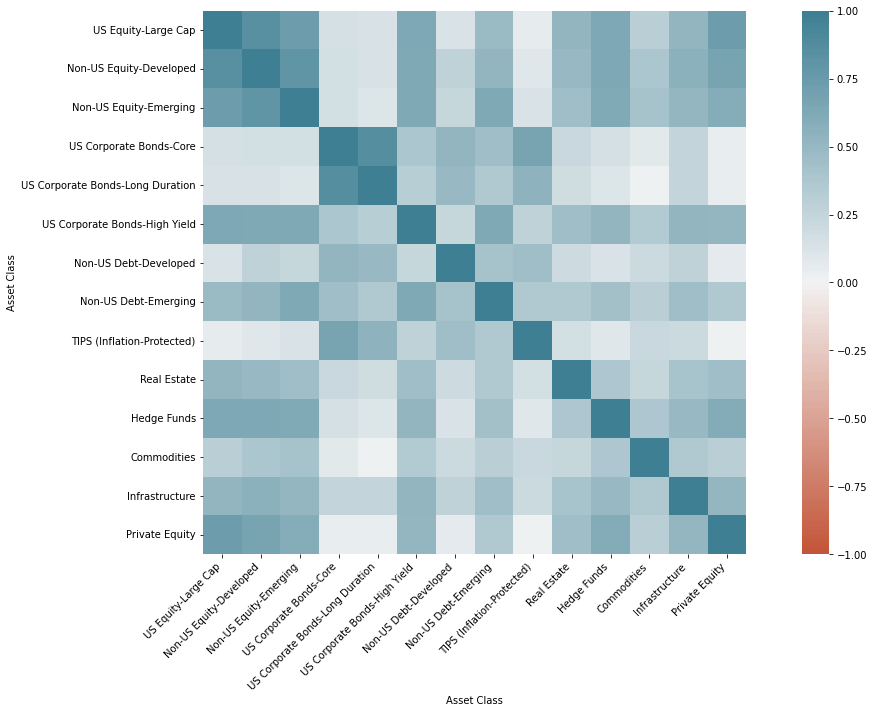

In [214]:
f, ax = plt.subplots(figsize=(20, 10))
ax = sn.heatmap(
    df_Corr_a, 
    vmin=-1, vmax=1, center=0,
    cmap=sn.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

### Create Covariance Matrix by

$$\Sigma_a=diag(\sigma_X) \times Corr_{XX} \times diag(\sigma_X)$$

In [215]:
# Compute Covariance Matrix
df_diag_std = np.diag(df_CMAs_Returns['Std Dev'])

df_Sigma_a = pd.DataFrame(df_diag_std.dot(df_Corr_a).dot(df_diag_std))

df_Sigma_a.set_axis(ordered_asset_classes, axis=1, inplace=True)
df_Sigma_a.set_axis(ordered_asset_classes, axis=0, inplace=True)

df_Sigma_a.round(4).style.background_gradient(cmap='coolwarm', axis=None)
# sn.heatmap(df_Sigma_a.round(4), annot=True, fmt='g')
# plt.show()

,US Equity-Large Cap,Non-US Equity-Developed,Non-US Equity-Emerging,US Corporate Bonds-Core,US Corporate Bonds-Long Duration,US Corporate Bonds-High Yield,Non-US Debt-Developed,Non-US Debt-Emerging,TIPS (Inflation-Protected),Real Estate,Hedge Funds,Commodities,Infrastructure,Private Equity
US Equity-Large Cap,0.026300,0.024600,0.028700,0.001300,0.002300,0.010000,0.001400,0.008500,0.000500,0.014500,0.008200,0.008800,0.012500,0.026000
Non-US Equity-Developed,0.024600,0.032600,0.035000,0.001700,0.002600,0.010900,0.003500,0.010300,0.001000,0.014900,0.009100,0.012400,0.014700,0.026600
Non-US Equity-Emerging,0.028700,0.035000,0.058700,0.002100,0.002700,0.014600,0.003900,0.016500,0.001900,0.018000,0.011800,0.017900,0.018000,0.031400
US Corporate Bonds-Core,0.001300,0.001700,0.002100,0.003000,0.004800,0.002000,0.002000,0.002600,0.002200,0.002000,0.000700,0.000800,0.002000,0.000500
US Corporate Bonds-Long Duration,0.002300,0.002600,0.002700,0.004800,0.010300,0.003200,0.003500,0.004000,0.003300,0.003100,0.000900,0.000200,0.003700,0.000900
US Corporate Bonds-High Yield,0.010000,0.010900,0.014600,0.002000,0.003200,0.009500,0.001600,0.006600,0.001600,0.007600,0.004100,0.006000,0.007500,0.010900
Non-US Debt-Developed,0.001400,0.003500,0.003900,0.002000,0.003500,0.001600,0.004900,0.003200,0.001900,0.002200,0.000700,0.002600,0.002900,0.001100
Non-US Debt-Emerging,0.008500,0.010300,0.016500,0.002600,0.004000,0.006600,0.003200,0.012000,0.002400,0.006700,0.003800,0.005800,0.007200,0.008700
TIPS (Inflation-Protected),0.000500,0.001000,0.001900,0.002200,0.003300,0.001600,0.001900,0.002400,0.003700,0.001700,0.000500,0.002300,0.001800,0.000100
Real Estate,0.014500,0.014900,0.018000,0.002000,0.003100,0.007600,0.002200,0.006700,0.001700,0.028400,0.005000,0.006800,0.009800,0.017000


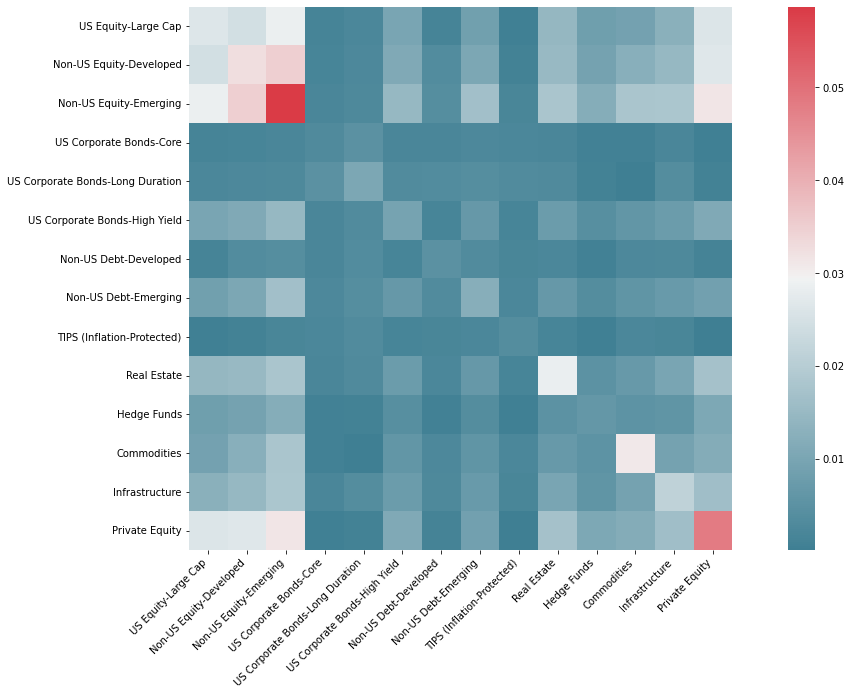

In [216]:
f, ax = plt.subplots(figsize=(20, 10))
ax = sn.heatmap(
    df_Sigma_a, 
    vmin=df_Sigma_a.min().min(), vmax=df_Sigma_a.max().max(),
    cmap=sn.diverging_palette(220, 10, as_cmap=True),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

## Step 2: Calculate factor loadings and factor risk premiums

### 2.1 Factor-Mimicking Portfolio Definition: $\omega_{mf}$ and $\hat{\omega}_{pf}$

In [217]:
weights = np.zeros((14,4), float)
df_factor_mimic_portfolios = pd.DataFrame(weights,columns=ls_factors_full)
df_factor_mimic_portfolios.set_axis(ordered_asset_classes, axis=0, inplace=True)

# Economic Growth Factor definition
df_factor_mimic_portfolios.loc['US Equity-Large Cap', 'Economic Growth'] = 0.25
df_factor_mimic_portfolios.loc['Non-US Equity-Developed', 'Economic Growth'] = 0.20
df_factor_mimic_portfolios.loc['Non-US Equity-Emerging', 'Economic Growth'] = 0.10
df_factor_mimic_portfolios.loc['Commodities', 'Economic Growth'] = 0.10

# Real Rate Factor definition
df_factor_mimic_portfolios.loc['TIPS (Inflation-Protected)','Real Rate'] = 1.65

# Inflation Factor definition
df_factor_mimic_portfolios.loc['US Corporate Bonds-Core','Inflation'] = -1.60
df_factor_mimic_portfolios.loc['TIPS (Inflation-Protected)','Inflation'] = 1.60
df_factor_mimic_portfolios.loc['Commodities','Inflation'] = 0.30

# Private Factor definition
df_factor_mimic_portfolios.loc['Real Estate','Private Specific'] = 0.4
df_factor_mimic_portfolios.loc['Infrastructure','Private Specific'] = 0.4
df_factor_mimic_portfolios.loc['Private Equity','Private Specific'] = 0.4

df_factor_mimic_portfolios


,Economic Growth,Real Rate,Inflation,Private Specific
US Equity-Large Cap,0.25,0.00,0.0,0.0
Non-US Equity-Developed,0.20,0.00,0.0,0.0
Non-US Equity-Emerging,0.10,0.00,0.0,0.0
US Corporate Bonds-Core,0.00,0.00,-1.6,0.0
US Corporate Bonds-Long Duration,0.00,0.00,0.0,0.0
US Corporate Bonds-High Yield,0.00,0.00,0.0,0.0
Non-US Debt-Developed,0.00,0.00,0.0,0.0
Non-US Debt-Emerging,0.00,0.00,0.0,0.0
TIPS (Inflation-Protected),0.00,1.65,1.6,0.0
Real Estate,0.00,0.00,0.0,0.4


### 2.2 Compute Macroeconomic Factor Loadings

#### Compute $\beta_{mf}$ as

$$\beta_{mf}=\Sigma_a \omega_{mf}(\omega_{mf}^{\prime} \Sigma_a \omega_{mf})^{-1}$$

This definition of factor loadings is none other than an estimate of those factor loadings using a time-series regression: $ R_A = \beta R_F + \varepsilon $

where $R_A$ is the asset returns and $ R_F = \omega' R_A $

$$\hat{\beta}=R_A R_F'[R_F R_F']^{-1}={{1}\over{T-1}}R_A R_A' \omega \bigg[\omega'\bigg\lgroup {{1}\over{T-1}}R_A R_A' \bigg\rgroup \omega \bigg]^{-1}$$

In [218]:
# Compute beta mf

df_omega_mf = df_factor_mimic_portfolios[ls_pub_factor]

df_beta_mf = df_Sigma_a.dot(df_omega_mf).dot(np.linalg.inv(df_omega_mf.T.dot(df_Sigma_a).dot(df_omega_mf)))

df_beta_mf.set_axis(ls_pub_factor, axis=1, inplace=True)

round(df_beta_mf,2)

,Economic Growth,Real Rate,Inflation
US Equity-Large Cap,1.52,0.03,-0.27
Non-US Equity-Developed,1.71,0.05,-0.20
Non-US Equity-Emerging,2.10,0.09,-0.08
US Corporate Bonds-Core,0.13,0.56,-0.41
US Corporate Bonds-Long Duration,0.20,0.88,-0.72
US Corporate Bonds-High Yield,0.66,0.28,-0.20
Non-US Debt-Developed,0.16,0.38,-0.17
Non-US Debt-Emerging,0.62,0.44,-0.24
TIPS (Inflation-Protected),-0.00,0.61,-0.00
Real Estate,0.89,0.28,-0.21


### 2.3 Compute Private-Specific Factor Loadings

#### Compute the private-speicific factor-mimicking portfolio wieights $\omega_{pf}$ as

$$\omega_{pf}=\hat{\omega}_{pf}-\omega_{mf} \beta_{mf}^{\prime} \hat{\omega}_{pf}$$

where $\omega_{mf} \beta_{mf}^{\prime} \hat{\omega}_{pf}$ is the exposure to macroeconomic factors of the private assets' portfolio

In [219]:
df_hat_omega_pf = df_factor_mimic_portfolios[[ls_priv_factor]]

df_omega_pf = df_hat_omega_pf - df_omega_mf.dot(df_beta_mf.T).dot(df_hat_omega_pf)

df_omega_pf.round(2)

,Private Specific
US Equity-Large Cap,-0.33
Non-US Equity-Developed,-0.26
Non-US Equity-Emerging,-0.13
US Corporate Bonds-Core,-0.21
US Corporate Bonds-Long Duration,0.00
US Corporate Bonds-High Yield,0.00
Non-US Debt-Developed,0.00
Non-US Debt-Emerging,0.00
TIPS (Inflation-Protected),-0.03
Real Estate,0.40


#### Compute $\beta_f$ as

$$\beta_{f}=\Sigma_a \omega_{f}(\omega_{f}^{\prime} \Sigma_a \omega_{f})^{-1} \circ I$$

Where

$$\omega_f:=[\omega_{mf}\omega_{pf}]$$
$$I:=[I_{mf} I_{pf}]$$



#### $\omega_f$

In [220]:
df_omega_f = df_omega_mf.join(df_omega_pf)
df_omega_f.round(2)

,Economic Growth,Real Rate,Inflation,Private Specific
US Equity-Large Cap,0.25,0.00,0.0,-0.33
Non-US Equity-Developed,0.20,0.00,0.0,-0.26
Non-US Equity-Emerging,0.10,0.00,0.0,-0.13
US Corporate Bonds-Core,0.00,0.00,-1.6,-0.21
US Corporate Bonds-Long Duration,0.00,0.00,0.0,0.00
US Corporate Bonds-High Yield,0.00,0.00,0.0,0.00
Non-US Debt-Developed,0.00,0.00,0.0,0.00
Non-US Debt-Emerging,0.00,0.00,0.0,0.00
TIPS (Inflation-Protected),0.00,1.65,1.6,-0.03
Real Estate,0.00,0.00,0.0,0.40


#### Compute $I$

Where

$I_{mf}$ is and $N \times M$ matrix of ones

$I_{pf}$ is and $N \times 1$ vector where an entry is equal to 1 for all private assets and 0 otherwise.

In [221]:
i = np.zeros((14,4)) + 1
i[:,3] = 0
i[(-5, -2, -1),3] = 1

#### Compute $\beta_f$

In [222]:
# compute beta f

df_Sigma_f = df_omega_f.T.dot(df_Sigma_a).dot(df_omega_f)

df_beta_f = df_Sigma_a.dot(df_omega_f).dot(np.linalg.inv(df_Sigma_f))
df_beta_f = df_beta_f.multiply(i)

df_beta_f.set_axis(ls_factors_full, axis=1, inplace=True)

df_beta_f.round(2)

,Economic Growth,Real Rate,Inflation,Private Specific
US Equity-Large Cap,1.52,0.03,-0.27,0.00
Non-US Equity-Developed,1.71,0.05,-0.20,-0.00
Non-US Equity-Emerging,2.10,0.09,-0.08,-0.00
US Corporate Bonds-Core,0.13,0.56,-0.41,-0.00
US Corporate Bonds-Long Duration,0.20,0.88,-0.72,0.00
US Corporate Bonds-High Yield,0.66,0.28,-0.20,0.00
Non-US Debt-Developed,0.16,0.38,-0.17,-0.00
Non-US Debt-Emerging,0.62,0.44,-0.24,0.00
TIPS (Inflation-Protected),0.00,0.61,0.00,0.00
Real Estate,0.89,0.28,-0.21,0.86


### Factor volatility and correlations from factor covariance matrixes

In [223]:
# factor covariance matrix
df_Sigma_f.round(4)


,Economic Growth,Real Rate,Inflation,Private Specific
Economic Growth,0.0104,0.0012,0.0025,0.0000
Real Rate,0.0012,0.0100,0.0050,0.0000
Inflation,0.0025,0.0050,0.0100,0.0000
Private Specific,0.0000,0.0000,0.0000,0.0116


In [224]:
# compute std and correlation from covariance matrix

df_factor_std, df_factor_correlation_matrix = correlation_from_covariance(df_Sigma_f)
df_factor_std = pd.DataFrame(df_factor_std,index=df_Sigma_f.columns)

In [225]:
# volatility
df_factor_std.round(4)

,0
Economic Growth,0.1021
Real Rate,0.0998
Inflation,0.0999
Private Specific,0.1076


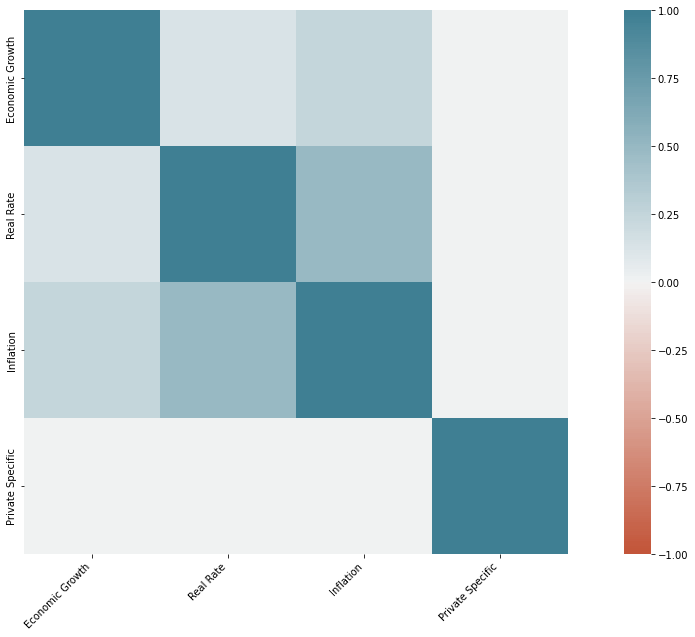

In [226]:
# factor correlation matrix
df_factor_correlation_matrix.round(2)

f, ax = plt.subplots(figsize=(20, 10))
ax = sn.heatmap(
    df_factor_correlation_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sn.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

### Estimating the Factor Risk Premiums

#### Approach 1:
$$\mu_f = \omega_f^{\prime}\mu_a$$

Where
$$\mu_a=expected\ return - 10\ yr\ treasury$$



In [278]:
# Risk Premium
# Approach 1

df_a_excess_returns = df_CMAs_Returns[['10Y-Geom-Return']] - risk_free_rate
df_a_excess_returns.rename(columns={"10Y-Geom-Return":report_year}, inplace=True)
df_f_excess_returns = df_omega_f.T.dot( df_a_excess_returns )

df_f_excess_returns.round(3)

,2020
Economic Growth,0.030
Real Rate,0.007
Inflation,-0.005
Private Specific,0.027


#### Approach 2:
$$\mu_{a,pub}=c_m+\beta_{mf,pub}\mu_{mf^*}+\epsilon$$
$$\mu_{a,priv}-\beta_{mf,priv}\mu_{mf^*}=c_p+\beta_{mf,priv}\mu_{pf^*}+\eta$$

In [228]:
# Approach 2
ls_pub = ['US Equity-Large Cap','Non-US Equity-Developed','Non-US Equity-Emerging','US Corporate Bonds-Core','US Corporate Bonds-Long Duration','US Corporate Bonds-High Yield','Non-US Debt-Developed','Non-US Debt-Emerging','TIPS (Inflation-Protected)','Commodities']

df_mu_a_pub = df_CMAs_Returns[df_CMAs_Returns.index.isin(ls_pub)][['10Y-Geom-Return']] - risk_free_rate
df_beta_mf_pub = df_beta_mf[df_beta_mf.index.isin(ls_pub)]

reg = LinearRegression().fit(df_beta_mf_pub, df_mu_a_pub)
c_m = reg.intercept_
estimated_risk_premium_macro = pd.DataFrame(reg.coef_, columns=ls_pub_factor).T
estimated_risk_premium_macro.round(3)

,0
Economic Growth,0.030
Real Rate,0.006
Inflation,-0.003


## Step 3: From Factors to Assets

### Optimizing the asset portfolio also repects the target factor exposure $\overline{w}_F$

$$\underset{w}{\argmin}
\gamma
(w^\prime\beta_f-\overline{w}^\prime_F)
(w^\prime\beta_f-\overline{w}^\prime_F)^\prime
+
(1-\gamma)
(w-\overline{w}_A)^\prime
(w-\overline{w}_A)$$

Where $\overline{w}_F$ is the desired(target) set of factor exposures, $\overline{w}_A$ is the target asset weights

##### Closed-form solution:

$$w=[\gamma\beta_f\beta^\prime_f+(1-\gamma)I_{N\times N}]^{-1}
(\gamma \beta_f \overline{w}_F
+
(1-\gamma)\overline{w}_A
)
$$

##### Let $\overline{w}_F$ be the mean-variance tangency factor portfolio and $\overline{w}_A$ to be the inverse volatility asset portfolio:

$$w=[\gamma\beta_f\beta^\prime_f
+(1-\gamma)I_{N\times N}]^{-1}
\bigg\lgroup
\gamma\beta_f{{\sum^{-1}_f \mu_f}\over{\mid \bold{1}^\prime_M \sum^{-1}_f \mu_f \mid}}
+(1-\gamma){{D^{-1}\bold{1}_N}\over{\mid \bold{1}^\prime_N D^{-1}\bold{1}_N\mid}}
\bigg\rgroup$$

Where $D$ is a diagonal matrix with the asset volatilites along its diagonal

##### Notes
Choosing inverse volatility approach over other risk-based approaches:
1. it avoids negative allocations to asset classes (negative weights could be undesirable for asset owners)
2. it enforces risk diversification across asset class line items
3. it is marginally affected by estimation error because it relies solely on volatility estimates, which are considerably more reliable than correlation or expected returns estimates

In [286]:
# Compute the factor to asset optimization

def factor_to_asset_optimization(gamma, m_factor, n_assets, df_beta_f, df_Sigma_f, df_f_excess_returns, df_diag_std):

    i_n_n = np.identity(n_assets)
    m_1 = np.ones((m_factor,1))
    n_1 = np.ones((n_assets,1))

    df_part_1 =  np.linalg.inv(gamma * (df_beta_f).dot(df_beta_f.T) + ( 1 - gamma ) * i_n_n)

    a = np.linalg.inv(df_Sigma_f).dot(df_f_excess_returns) / np.linalg.det(m_1.T.dot(np.linalg.inv(df_Sigma_f)).dot(df_f_excess_returns))

    df_part_2_1 = gamma * df_beta_f.dot(a)

    df_part_2_2 = ( 1 - gamma ) * np.linalg.inv(df_diag_std).dot(n_1) / np.linalg.det(n_1.T.dot(np.linalg.inv(df_diag_std)).dot(n_1))

    w = df_part_1.dot(df_part_2_1 + df_part_2_2)

    df_w = pd.DataFrame(w)

    df_w.set_axis(df_beta_f.index, axis=0, inplace=True)

    return(df_w)

gamma = 0.99
m_factor = 4
n_assets = len(df_beta_f.index)

df_w = factor_to_asset_optimization(gamma=gamma,m_factor=m_factor, n_assets=n_assets, df_beta_f=df_beta_f,
                                    df_Sigma_f=df_Sigma_f, df_f_excess_returns=df_f_excess_returns, df_diag_std=df_diag_std)
df_w.rename(columns={0:report_year}, inplace=True)
df_w.round(2)

,2020
US Equity-Large Cap,0.05
Non-US Equity-Developed,0.02
Non-US Equity-Emerging,-0.04
US Corporate Bonds-Core,0.12
US Corporate Bonds-Long Duration,0.06
US Corporate Bonds-High Yield,0.05
Non-US Debt-Developed,0.07
Non-US Debt-Emerging,0.02
TIPS (Inflation-Protected),0.01
Real Estate,0.19


In [288]:
# Compute implied Factor Exposure

df_w.T.dot(df_beta_f).T.set_axis([report_year], axis=1).round(2)

,2020
Economic Growth,0.65
Real Rate,0.26
Inflation,-0.40
Private Specific,0.48


In [292]:
# Compute Portfolio Std Dev

df_pf_std = df_w.T.dot(df_a_excess_returns) / np.sqrt(df_w.T.dot(df_Sigma_a).dot(df_w))
df_pf_std.round(4)

,2020
2020,0.3996
